<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/Danling/Danling_390_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from keras.layers import LSTM, Dense, Input
from keras.models import Sequential
from keras import Model
from keras.optimizers import Adam
import time as time
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train_final.csv', parse_dates = ['date'])
test = pd.read_csv('test_final.csv', parse_dates = ['date'])

In [3]:
# inspired by prophet, I am adding holidays as one-hot encoded variables
from prophet.make_holidays import make_holidays_df
us_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='US')
us_holidays['country_code'] ='US'
lu_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='LU')
lu_holidays['country_code'] ='LU'
ie_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='IE')
ie_holidays['country_code'] ='IE'
no_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='NO')
no_holidays['country_code'] = 'NO'
ch_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='CH')
ch_holidays['country_code'] = 'CH'
sg_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='SG')
sg_holidays['country_code'] = 'SG'
# qa_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='QA') Qatar is not supported
is_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='IS')
is_holidays['country_code'] = 'IS'
dk_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='DK')
dk_holidays['country_code'] = 'DK'
au_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='AU')
au_holidays['country_code'] = 'AU'

holidays = pd.concat([us_holidays, lu_holidays, ie_holidays, no_holidays, ch_holidays, sg_holidays, is_holidays, dk_holidays, au_holidays])

# Honestly I don't really care if what holiday it is, since there are so many in different countries
# however, I want to know if a specific day is a holiday or not.

holidays.holiday = 1

train_with_holiday = train.merge(holidays, how = 'left', left_on = ['date', 'country_code'], right_on = ['ds', 'country_code'])
train_with_holiday['holiday'].fillna(0, inplace = True)
test_with_holiday = test.merge(holidays, how = 'left', left_on = ['date', 'country_code'], right_on = ['ds', 'country_code'])
test_with_holiday['holiday'].fillna(0, inplace = True)

In [4]:
# drop useless columns
train_lstm = train_with_holiday.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'ds', 'country_code','new_confirmed_std1'])
test_lstm = test_with_holiday.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'ds', 'country_code','new_confirmed_std1'])

In [5]:
train_lstm.head()

,date,location_key_x,new_deceased,cumulative_deceased,population,population_male,population_female,latitude,longitude,area_sq_km,...,new_confirmed_min7,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,holiday
0,2020-01-22,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,2,1,1,2020,22,22,4,Winter,0.0
1,2020-01-23,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,3,1,1,2020,23,23,4,Winter,0.0
2,2020-01-24,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,4,1,1,2020,24,24,4,Winter,0.0
3,2020-01-25,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,5,1,1,2020,25,25,4,Winter,0.0
4,2020-01-26,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,6,1,1,2020,26,26,4,Winter,0.0


In [6]:
# one-hot encoding

# day of the week -- turns out there is a day_of_week column that has already been encoded
# however, Mon-Sun is from 0-6 and I want it to be 1-7
train_lstm['day_of_week']= train_lstm['day_of_week'] + 1
test_lstm['day_of_week']= test_lstm['day_of_week'] + 1


# season
season_train = pd.get_dummies(train_lstm['season'],drop_first=True)
season_test = pd.get_dummies(test_lstm['season'],drop_first=True)


train_lstm = pd.concat([train_lstm, season_train], axis = 1).drop(columns = ['season'])
test_lstm = pd.concat([test_lstm, season_test], axis = 1).drop(columns = ['season'])

In [7]:
# drop addtional rows

# Since I am modeling based on reagion, I don't need any information that is
# constant within a region.
for col in train_lstm.loc[:, train_lstm.nunique() <= 103].columns:
  print(col)

location_key_x
population
population_male
population_female
latitude
longitude
area_sq_km
life_expectancy
aggregation_level
gdp_usd
gdp_per_capita_usd
AG.LND.AGRI.K2
AG.LND.AGRI.ZS
AG.LND.ARBL.HA
AG.LND.ARBL.HA.PC
AG.LND.ARBL.ZS
AG.LND.CROP.ZS
AG.LND.FRST.K2
AG.LND.FRST.ZS
AG.LND.TOTL.K2
AG.PRD.CROP.XD
AG.PRD.FOOD.XD
AG.PRD.LVSK.XD
AG.SRF.TOTL.K2
BX.KLT.DINV.CD.WD
EG.ELC.ACCS.RU.ZS
EG.ELC.ACCS.UR.ZS
EG.ELC.ACCS.ZS
EG.ELC.RNEW.ZS
EG.FEC.RNEW.ZS
EN.ATM.CO2E.GF.KT
EN.ATM.CO2E.GF.ZS
EN.ATM.CO2E.KT
EN.ATM.CO2E.LF.KT
EN.ATM.CO2E.LF.ZS
EN.ATM.CO2E.PC
EN.ATM.CO2E.SF.KT
EN.ATM.CO2E.SF.ZS
EN.ATM.PM25.MC.M3
EN.ATM.PM25.MC.T1.ZS
EN.ATM.PM25.MC.T2.ZS
EN.ATM.PM25.MC.T3.ZS
EN.ATM.PM25.MC.ZS
EN.BIR.THRD.NO
EN.FSH.THRD.NO
EN.HPT.THRD.NO
EN.MAM.THRD.NO
EN.POP.DNST
ER.FSH.CAPT.MT
ER.FSH.PROD.MT
ER.LND.PTLD.ZS
ER.PTD.TOTL.ZS
IP.JRN.ARTC.SC
IT.CEL.SETS
IT.CEL.SETS.P2
IT.MLT.MAIN
IT.MLT.MAIN.P2
IT.NET.BBND
IT.NET.BBND.P2
IT.NET.SECR
IT.NET.SECR.P6
IT.NET.USER.ZS
NV.IND.TOTL.CN
NV.IND.TOTL.ZS
NY.ADJ.AEDU.GN.

In [8]:
# select columns of interest only
col_to_keep = ['location_key_x', 'day_of_week', 'quarter', 'month', 'year','dayofmonth','weekofyear','Spring','Summer','Winter','holiday']
addtional_col = train_lstm.loc[:, train_lstm.nunique() > 103].columns.to_list()
for col in addtional_col:
  col_to_keep.append(col)

train_sel = train_lstm[col_to_keep]
test_sel = test_lstm[col_to_keep]

# put zeros to missing lagging features
train_sel.fillna(0, inplace = True)
test_sel.fillna(0, inplace = True)

In [9]:
train_date = train_sel.date
test_date = test_sel.date
train_no_date = train_sel.drop(columns = 'date')
test_no_date = test_sel.drop(columns = 'date')

In [10]:
data = pd.concat([train_no_date, test_no_date])
date_all = pd.concat([train_date, test_date])

Select out location of interest: US_AK

In [11]:
AK_date = date_all.loc[data.location_key_x == 'US_AK']
AK_data = data.loc[data.location_key_x == 'US_AK'].drop(columns = ['location_key_x']).astype(float)
AK_data.index = AK_date

Scale the dataset

In [25]:
scaler = StandardScaler()
AK_scaled = pd.DataFrame(data = scaler.fit_transform(AK_data), index = AK_data.index, columns = AK_data.columns)
AK_scaled['new_confirmed'] = AK_data['new_confirmed']

In [26]:
def make_series(data):
    series=[]
    for i in range(len(data)-14):
        subdf=data[i:i+14]
        series.append((data.index[-1], data['new_confirmed'].values[-1], subdf.drop('new_confirmed', axis=1).values))
    return series
series=make_series(AK_scaled)
print(series[0][0],series[0][1].shape,series[0][2].shape)
AK_train = series[:AK_scaled.loc[AK_scaled.index < '2022-01-01'].shape[0]]
AK_test = series[AK_scaled.loc[AK_scaled.index < '2022-01-01'].shape[0]-14:]

2022-09-15 00:00:00 () (14, 27)


In [27]:
AK_train[365]

(Timestamp('2022-09-15 00:00:00'),
 0.0,
 array([[ 1.00051854e+00, -1.30411215e+00, -1.58742639e+00,
          1.12315622e-01,  8.29463227e-01, -1.55563431e+00,
         -6.32914332e-01, -6.32914332e-01,  1.85110926e+00,
         -1.76019618e-01, -1.59442332e-01, -5.06680351e-01,
          5.65974095e-01,  8.37289246e-01, -1.04963159e+00,
         -1.18712089e-01, -2.19395219e-01, -8.00890252e-02,
         -1.65473067e-01, -2.66705007e-01, -2.08444412e-01,
         -3.49824329e-01, -2.05943493e-01, -2.94414498e-01,
         -1.57318063e-01, -1.19468264e-01, -1.50336390e+00],
        [ 1.50025994e+00, -1.30411215e+00, -1.58742639e+00,
          1.12315622e-01,  9.42822810e-01, -1.55563431e+00,
         -6.32914332e-01, -6.32914332e-01,  1.85110926e+00,
         -1.76019618e-01, -6.02848241e-01, -5.06680351e-01,
          6.52133584e-01,  4.27598495e-01, -1.04456192e+00,
         -3.01553482e-01, -5.23299635e-02, -3.36540184e-01,
         -3.19924585e-01, -2.91132403e-01, -1.70491552e-02

Training

In [35]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =14

In [36]:
inputs = Input(shape=(14,27))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 27)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                7680      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7713 (30.13 KB)
Trainable params: 7713 (30.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
x=np.array([x[2].reshape(14,27) for x in AK_train])
y=np.array([x[1] for x in AK_train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(707, 14, 27)
(707,)
Epoch 1/100
23/23 [==============================] - 2s 4ms/step - loss: 0.0800
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 5.8653e-04
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 6.0475e-04
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 4.6071e-04
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 3.5665e-04
Epoch 8/100
23/23 [==============================] - 0s 4ms/step - loss: 3.1817e-04
Epoch 9/100
23/23 [==============================] - 0s 4ms/step - loss: 2.6472e-04
Epoch 10/100
23/23 [==============================] - 0s 4ms/step - loss: 2.2574e-04
Epoch 11/100
23/23 [==============================] - 0s 4ms/step - loss: 2.6568e-04
Epoch 12/100
23/23 [==============================] - 0s 4ms/step

In [38]:
AK_train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in AK_train])
AK_test_pred = pd.DataFrame(model.predict(np.array([x[2].reshape(14,27) for x in AK_test])), columns=['yhat'], index=[x[0] for x in AK_test ])

9/9 [==============================] - 0s 2ms/step


In [27]:
# reverse scaling
AK_train_df = AK_scaled.loc[AK_scaled.index < '2022-01-01']
AK_train_for_rescale = AK_train_df.copy()
AK_train_pred.index = AK_train_for_rescale.index
AK_train_for_rescale.new_confirmed = AK_train_pred
# AK_train_for_rescale = AK_train_for_rescale.rename(columns = {'new_confirmed':'new_confirmed_pred'})
AK_train_pred_df = pd.DataFrame(scaler.inverse_transform(AK_train_for_rescale), index = AK_train_for_rescale.index, columns = AK_train_for_rescale.columns)
AK_train_pred_df.new_confirmed.max()

11.950249308367006

In [47]:
pd.DataFrame(scaler.inverse_transform(AK_scaled), index = AK_scaled.index, columns = AK_scaled.columns)


,day_of_week,quarter,month,year,dayofmonth,weekofyear,Spring,Summer,Winter,holiday,...,new_confirmed_lag7,new_confirmed_mean3,new_confirmed_mean7,new_confirmed_std3,new_confirmed_std7,new_confirmed_max3,new_confirmed_max7,new_confirmed_min3,new_confirmed_min7,dayofyear
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,-0.498447,-1.303436,-1.586604,-1.162194,0.715733,-1.484653,-0.632586,-0.632586,1.850150,-0.175928,...,-0.684394,-0.719647,-0.743930,-0.609698,-0.703926,-0.739576,-0.777904,-0.659391,-0.748251,-1.512660
2020-01-23,0.001035,-1.303436,-1.586604,-1.162194,0.829033,-1.484653,-0.632586,-0.632586,1.850150,-0.175928,...,-0.684394,-0.719647,-0.743930,-0.609698,-0.703926,-0.739576,-0.777904,-0.659391,-0.748251,-1.502585
2020-01-24,0.500518,-1.303436,-1.586604,-1.162194,0.942334,-1.484653,-0.632586,-0.632586,1.850150,-0.175928,...,-0.684394,-0.719647,-0.743930,-0.609698,-0.703926,-0.739576,-0.777904,-0.659391,-0.748251,-1.492510
2020-01-25,1.000000,-1.303436,-1.586604,-1.162194,1.055635,-1.484653,-0.632586,-0.632586,1.850150,-0.175928,...,-0.684394,-0.719647,-0.743930,-0.609698,-0.703926,-0.739576,-0.777904,-0.659391,-0.748251,-1.482435
2020-01-26,1.499482,-1.303436,-1.586604,-1.162194,1.168936,-1.484653,-0.632586,-0.632586,1.850150,-0.175928,...,-0.684394,-0.719647,-0.743930,-0.609698,-0.703926,-0.739576,-0.777904,-0.659391,-0.748251,-1.472360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-11,1.499482,0.576707,0.872457,1.386709,-0.530577,0.760943,-0.632586,-0.632586,-0.539937,-0.175928,...,-0.522138,-0.719647,-0.173645,-0.609698,2.840649,-0.739576,1.733799,-0.659391,-0.748251,0.824725
2022-09-12,-1.497412,0.576707,0.872457,1.386709,-0.417276,0.831118,-0.632586,-0.632586,-0.539937,-0.175928,...,-0.512732,-0.719647,-0.200246,-0.609698,2.869648,-0.739576,1.733799,-0.659391,-0.748251,0.834799
2022-09-13,-0.997930,0.576707,0.872457,1.386709,-0.303975,0.831118,-0.632586,-0.632586,-0.539937,-0.175928,...,-0.460998,-0.719647,-0.234864,-0.609698,2.902331,-0.739576,1.733799,-0.659391,-0.748251,0.844874


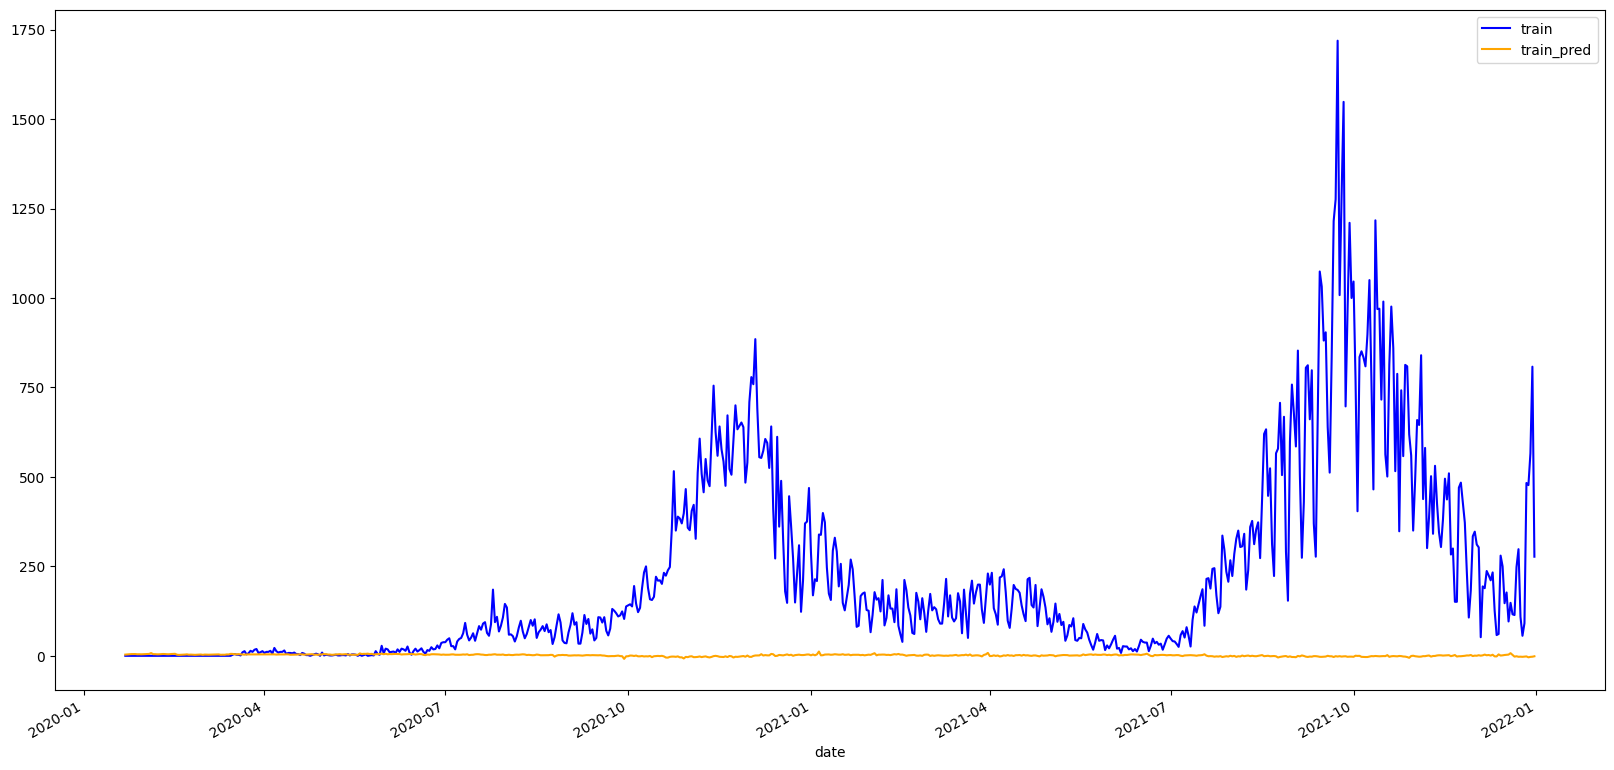

In [44]:
y_train_pred = AK_train_pred_df.new_confirmed
y_train_real = train.loc[train.location_key_x == 'US_AK', 'new_confirmed']
y_train_real.index = train.loc[train.location_key_x == 'US_AK', 'date']

y_train_real.plot(figsize=(20,10), color = 'blue')
y_train_pred.plot(figsize=(20,10), color = 'orange')
# pd.concat([y_train_pred, y_train_real], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])